# Einlesen der Daten

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from Code.S02_Allgemein.process_hdf5 import plot_from_exp_id

plt.rcParams['figure.figsize'] = [13, 10] # Größe der Figure festsetzen

In [2]:
path = r"C:\Users\timbr\OneDrive\Masterarbeit\Daten\2020_09_17_Monte_Carlo_4_final\\"
h5_filename1 = "2020_09_20__13_22_37_Monte_Carlo_Data.hdf5"
filename1 = "2020_09_20__13_22_37_Monte_Carlo_DataFrame.pkl"
df_raw = pd.read_pickle(path+filename1)

Plot mit gefiltertem Füllstand!


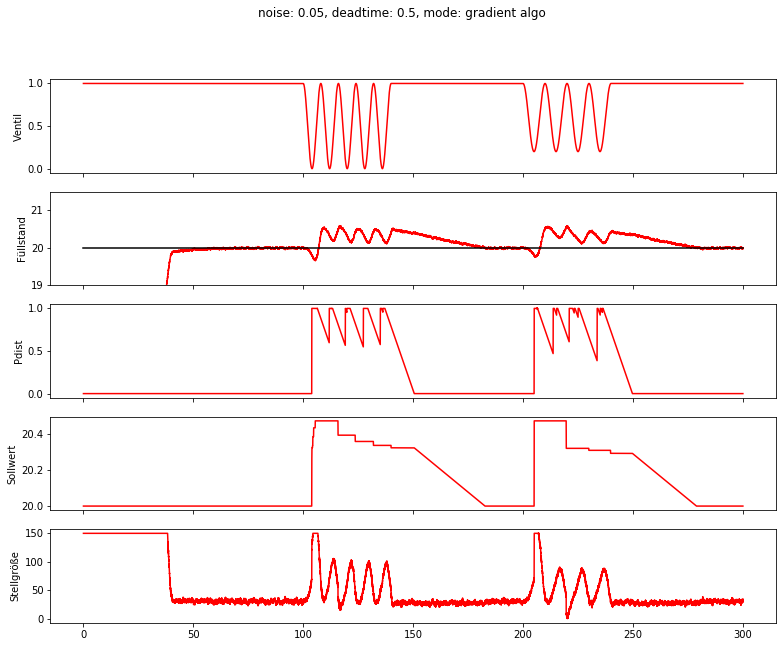

In [3]:
plot_from_exp_id(path, h5_filename1, 1)

In [4]:
# nicht benötigte Spalten löschen
df_raw.drop(['A', 'deadtime', 'dist_id', 'dist_name', 'model_qual', 'noise_sigma', 'q', 'react_mode', 'sigma',
       'false_neg_count', 'false_pos_count', 'fn_dist', 'fp_dist',
       'resloss_sum', 'time_to_detect',
       'time_to_recover', 'yexceed+5%', 'yexceed_dist', 'signal_power',
       'fn_dist1', 'fn_dist2', 'fp_dist1',
       'fp_dist2', 'max_loss1', 'max_loss2', 'resloss_dist1', 'resloss_dist2', 'time_to_recover1',
       'time_to_recover2', 'yexceed_dist1', 'yexceed_dist2', 'signal_power1',
       'signal_power2', 'resloss_dist', 'max_loss', 'fp_new'], axis=1, inplace=True)

df_raw['dist_len1'] = [i[-1] for i in df_raw['dist_name1'].str.split('_')]
df_raw['dist_len2'] = [i[-1] for i in df_raw['dist_name2'].str.split('_')]

# in numerische Spalten umwandeln
numeric_columns = ['overlap', 'rt_noise1', 'rt_noise2', 'time_to_detect1', 'time_to_detect2', 'dist_len1', 'dist_len2']
for i in numeric_columns:
    df_raw[i] = df_raw[i].apply(pd.to_numeric, errors='coerce')

# filtern von ungültigen Simulationen
df = df_raw[(df_raw['disq']==0)] # & (df_raw['dist_len1']==40) & (df_raw['dist_len2']==40)]

In [8]:
df_raw[df_raw['detect_mode'] != 'model ar l'].shape

(1372, 14)

# Lerneffekt

nach gleichem Verfahren und gleicher Störung gruppiert, jeweils für erste und zweite Störung

In [135]:
df_rt1 = df[['detect_mode', 'dist_name1', 'rt_noise1', 'time_to_detect1']]
df_rt1.rename(columns={"dist_name1": "dist_name"}, inplace=True)
df_rt1 = df_rt1.groupby(['detect_mode', 'dist_name']).mean()

df_rt2 = df[['detect_mode', 'dist_name2', 'rt_noise2', 'time_to_detect2']]
df_rt2.rename(columns={"dist_name2": "dist_name"}, inplace=True)
df_rt2 = df_rt2.groupby(['detect_mode', 'dist_name']).mean()

df_merge = df_rt1.merge(df_rt2, on=['detect_mode', 'dist_name'])
df_merge['lerneffekt_overall'] = df_merge['rt_noise1'] - df_merge['rt_noise2']
df_learn = df_merge.groupby('detect_mode').mean()

C:\Users\timbr\anaconda3\lib\site-packages\pandas\core\frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [137]:
df_learn

,rt_noise1,time_to_detect1,rt_noise2,time_to_detect2,lerneffekt_overall
detect_mode,,,,,
detect_dummy,16.986375,199.980000,16.942723,99.980000,0.043652
dtw mean algo,7.941371,12.858500,7.955588,13.342299,-0.014217
gradient algo,3.838159,18.780771,3.461993,9.099849,0.376166
model algo full,6.531532,4.430978,5.925642,4.392520,0.605890
model arima l,5.742700,4.314141,5.081054,4.372727,0.661645
pelt5,6.872250,4.018604,9.187152,14.707477,-2.314902
pelt_minmax,7.273657,5.308776,7.259188,5.538878,0.014469


# Störerkennung

In [138]:
df['fn1'] = 0
df['fn2'] = 0
df.loc[df['time_to_detect1'] >= df['dist_len1'], ['fn1']] = 1
df.loc[df['time_to_detect2'] >= df['dist_len2'], ['fn2']] = 1
#df.loc[df['time_to_detect1'] >= df['dist_len1'], ['time_to_detect1']] = df['dist_len1']
#df.loc[df['time_to_detect2'] >= df['dist_len2'], ['time_to_detect2']] = df['dist_len2']
df['fn'] = 0.5*(df['fn1'] + df['fn2'])

C:\Users\timbr\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\timbr\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\timbr\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

In [139]:
df_tp = df[(df['time_to_detect1'] < df['dist_len1']) & (df['time_to_detect2'] < df['dist_len2'])]
df_tp['ttd'] = 0.5*(df_tp['time_to_detect1'] + df_tp['time_to_detect2'])

df_fn = df.groupby(['detect_mode']).mean()
df_ttd = df_tp.groupby(['detect_mode']).mean()

C:\Users\timbr\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [140]:
df_learn['ttd'] = df_ttd['ttd']
df_learn['fn'] = df_fn['fn']
df_learn['overlap'] = df_fn['overlap']

In [141]:
df_learn.round(2).sort_values(by='lerneffekt_overall', ascending=False)

,rt_noise1,time_to_detect1,rt_noise2,time_to_detect2,lerneffekt_overall,ttd,fn,overlap
detect_mode,,,,,,,,
model arima l,5.74,4.31,5.08,4.37,0.66,4.34,0.00,0.85
model algo full,6.53,4.43,5.93,4.39,0.61,4.42,0.00,0.85
gradient algo,3.84,18.78,3.46,9.10,0.38,5.18,0.09,0.81
detect_dummy,16.99,199.98,16.94,99.98,0.04,NaN,1.00,0.57
pelt_minmax,7.27,5.31,7.26,5.54,0.01,5.42,0.00,0.80
dtw mean algo,7.94,12.86,7.96,13.34,-0.01,7.31,0.05,0.79
pelt5,6.87,4.02,9.19,14.71,-2.31,7.50,0.09,0.56


In [142]:
df_learn.round(2).sort_values(by='lerneffekt_overall', ascending=False).to_csv('MC4.csv')